# São Paulo Subway - EDA Passenger Transported Demand by line

from August 2018 to April 2023.

## Preprocessing dataset

Import libaries

In [3]:
from matplotlib.style import use

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
use('seaborn-v0_8')

Read CSV file.

In [4]:
PATH = 'alllines_ptl_complete.csv'
df = pd.read_csv(PATH)
display(df)

,year_month,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
0,2018-08-01,3,38679000.0,1440000.0,884000.0,504000.0,1483000.0
1,2018-08-01,1,37775000.0,1420000.0,832000.0,446000.0,1466000.0
2,2018-08-01,15,516000.0,22000.0,NaN,2000.0,23000.0
3,2018-08-01,2,18164000.0,701000.0,318000.0,194000.0,723000.0
4,2018-08-01,5,7220000.0,309000.0,176000.0,85000.0,322000.0
...,...,...,...,...,...,...,...
337,2023-04-01,2,14544000.0,649000.0,299000.0,189000.0,671000.0
338,2023-04-01,4,15070570.0,661450.0,338300.0,201580.0,701710.0
339,2023-04-01,5,11792220.0,510810.0,282420.0,160710.0,527250.0
340,2023-04-01,1,25545000.0,1091000.0,639000.0,375000.0,1130000.0


In [5]:
df.set_index('year_month', inplace=True)
display(df)

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2018-08-01,3,38679000.0,1440000.0,884000.0,504000.0,1483000.0
2018-08-01,1,37775000.0,1420000.0,832000.0,446000.0,1466000.0
2018-08-01,15,516000.0,22000.0,NaN,2000.0,23000.0
2018-08-01,2,18164000.0,701000.0,318000.0,194000.0,723000.0
2018-08-01,5,7220000.0,309000.0,176000.0,85000.0,322000.0
...,...,...,...,...,...,...
2023-04-01,2,14544000.0,649000.0,299000.0,189000.0,671000.0
2023-04-01,4,15070570.0,661450.0,338300.0,201580.0,701710.0
2023-04-01,5,11792220.0,510810.0,282420.0,160710.0,527250.0


### Missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 2018-08-01 to 2023-04-01
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   line                      342 non-null    int64  
 1   total                     339 non-null    float64
 2   MDU (Business Days Mean)  339 non-null    float64
 3   MSD (Saturdays Mean)      337 non-null    float64
 4   MDO (Sundays Mean)        339 non-null    float64
 5   MAX (Daily Max)           339 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 18.7+ KB


In [7]:
df.isnull().sum()

line                        0
total                       3
MDU (Business Days Mean)    3
MSD (Saturdays Mean)        5
MDO (Sundays Mean)          3
MAX (Daily Max)             3
dtype: int64

In [8]:
df.loc[df.isnull().any(axis=1)]

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2018-08-01,15,516000.0,22000.0,NaN,2000.0,23000.0
2018-10-01,15,498000.0,22000.0,NaN,4000.0,25000.0
2020-03-01,15,NaN,NaN,NaN,NaN,NaN
2020-04-01,15,NaN,NaN,NaN,NaN,NaN
2020-05-01,15,NaN,NaN,NaN,NaN,NaN


Following the administrator's information for the period from March 2020 to May 2020 line 15 was closed because of an
inspection of train fleet. The reason was the rupture of a tire of a composition.

For August 2018 and October 2018, there isn't information about the missing values.

Moreover, 11/03 was announced the by World Health Organization the Coronavirus pandemic. 

So, from this informations, I will fill the NaN values as follow:

1. August and October 2019, filled with forward value.

2. March 2020 filled with weighted mean, 33% February 2020 and 66% for value of first month forward with non-missing value (it's June 2020);

3. April and May filled with the value of first month forward with non-missing value (it's June 2020).

#### August 2019 and October 2019

In [9]:
august_fill = df[df['line'] == 15].loc['2018-09-01', 'MSD (Saturdays Mean)']
october_fill = df[df['line'] == 15].loc['2018-11-01', 'MSD (Saturdays Mean)']
print(august_fill, october_fill)

3000.0 6000.0


In [10]:
df.fillna(value={'MSD (Saturdays Mean)':august_fill}, limit=1, inplace=True)

In [11]:
df[df['line'] == 15].loc['2018-08-01']

line                            15.0
total                       516000.0
MDU (Business Days Mean)     22000.0
MSD (Saturdays Mean)          3000.0
MDO (Sundays Mean)            2000.0
MAX (Daily Max)              23000.0
Name: 2018-08-01, dtype: float64

In [12]:
df.loc[df.isnull().any(axis=1)]

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2018-10-01,15,498000.0,22000.0,NaN,4000.0,25000.0
2020-03-01,15,NaN,NaN,NaN,NaN,NaN
2020-04-01,15,NaN,NaN,NaN,NaN,NaN
2020-05-01,15,NaN,NaN,NaN,NaN,NaN


In [13]:
df.fillna(value={'MSD (Saturdays Mean)':october_fill}, limit=1, inplace=True)

In [14]:
df[df['line'] == 15].loc['2018-10-01']

line                            15.0
total                       498000.0
MDU (Business Days Mean)     22000.0
MSD (Saturdays Mean)          6000.0
MDO (Sundays Mean)            4000.0
MAX (Daily Max)              25000.0
Name: 2018-10-01, dtype: float64

In [15]:
df.loc[df.isnull().any(axis=1)]

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2020-03-01,15,NaN,NaN,NaN,NaN,NaN
2020-04-01,15,NaN,NaN,NaN,NaN,NaN
2020-05-01,15,NaN,NaN,NaN,NaN,NaN


#### March 2020

In [16]:
df[df['line'] == 15].loc['2020-02-01','total':]

total                       2497000.0
MDU (Business Days Mean)     116000.0
MSD (Saturdays Mean)          60000.0
MDO (Sundays Mean)            27000.0
MAX (Daily Max)              122000.0
Name: 2020-02-01, dtype: float64

In [17]:
march_fill = (df[df['line'] == 15].loc['2020-02-01','total':] * 3.3 + df[df['line'] == 15].loc['2020-06-01', 'total':] * 6.7) / 10
print(f'march 2020 will be filled with:\n {march_fill}')

march 2020 will be filled with:
 total                       1268220.0
MDU (Business Days Mean)      56370.0
MSD (Saturdays Mean)          29850.0
MDO (Sundays Mean)            14940.0
MAX (Daily Max)               66390.0
dtype: float64


In [18]:
march_fil_values = dict(zip(df.columns[1:], march_fill))
df.fillna(value=march_fil_values, limit=1, inplace=True)

In [19]:
df[df['line'] == 15].loc['2020-03-01']

line                             15.0
total                       1268220.0
MDU (Business Days Mean)      56370.0
MSD (Saturdays Mean)          29850.0
MDO (Sundays Mean)            14940.0
MAX (Daily Max)               66390.0
Name: 2020-03-01, dtype: float64

In [20]:
df.loc[df.isnull().any(axis=1)]

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2020-04-01,15,NaN,NaN,NaN,NaN,NaN
2020-05-01,15,NaN,NaN,NaN,NaN,NaN


#### Abril 2020 and May 2020

In [21]:
df.fillna(value=df[df['line'] == 15].loc['2020-06-01'], limit=2, inplace=True)

In [22]:
df.loc[df.isnull().any(axis=1)]

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,


In [23]:
df[df['line'] == 15].loc['2020-03-01': '2020-07-01']

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2020-03-01,15,1268220.0,56370.0,29850.0,14940.0,66390.0
2020-04-01,15,663000.0,27000.0,15000.0,9000.0,39000.0
2020-05-01,15,663000.0,27000.0,15000.0,9000.0,39000.0
2020-06-01,15,663000.0,27000.0,15000.0,9000.0,39000.0
2020-07-01,15,1161000.0,44000.0,26000.0,13000.0,49000.0


In [24]:
df.isnull().sum()

line                        0
total                       0
MDU (Business Days Mean)    0
MSD (Saturdays Mean)        0
MDO (Sundays Mean)          0
MAX (Daily Max)             0
dtype: int64

## Visualization

In [25]:
color_lines = {1: 'blue', 2: 'green', 3: 'red', 4: 'yellow', 5: 'purple', 15: 'gray'}

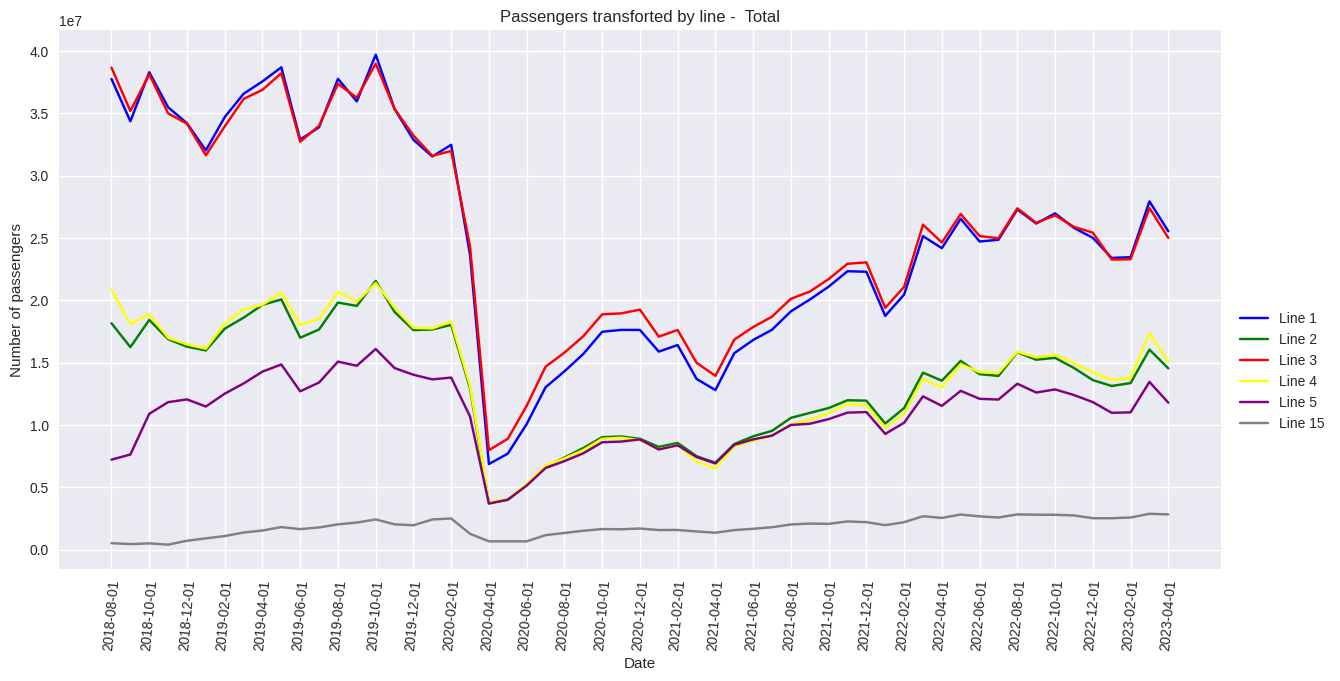

In [26]:
figure = plt.figure(figsize=(15,7))
plt.plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'total'], label='Line 1', color=color_lines[1])
plt.plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'total'], label='Line 2', color=color_lines[2])
plt.plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'total'], label='Line 3', color=color_lines[3])
plt.plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'total'], label='Line 4', color=color_lines[4])
plt.plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'total'], label='Line 5', color=color_lines[5])
plt.plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'total'], label='Line 15', color=color_lines[15])
plt.title('Passengers transforted by line -  Total')
plt.xlabel('Date')
plt.xticks(ticks=list(np.unique(df.index))[::2], rotation=85)
plt.ylabel('Number of passengers')
plt.legend(bbox_to_anchor=(0.6, 0., 0.5, 0.5))
plt.show()



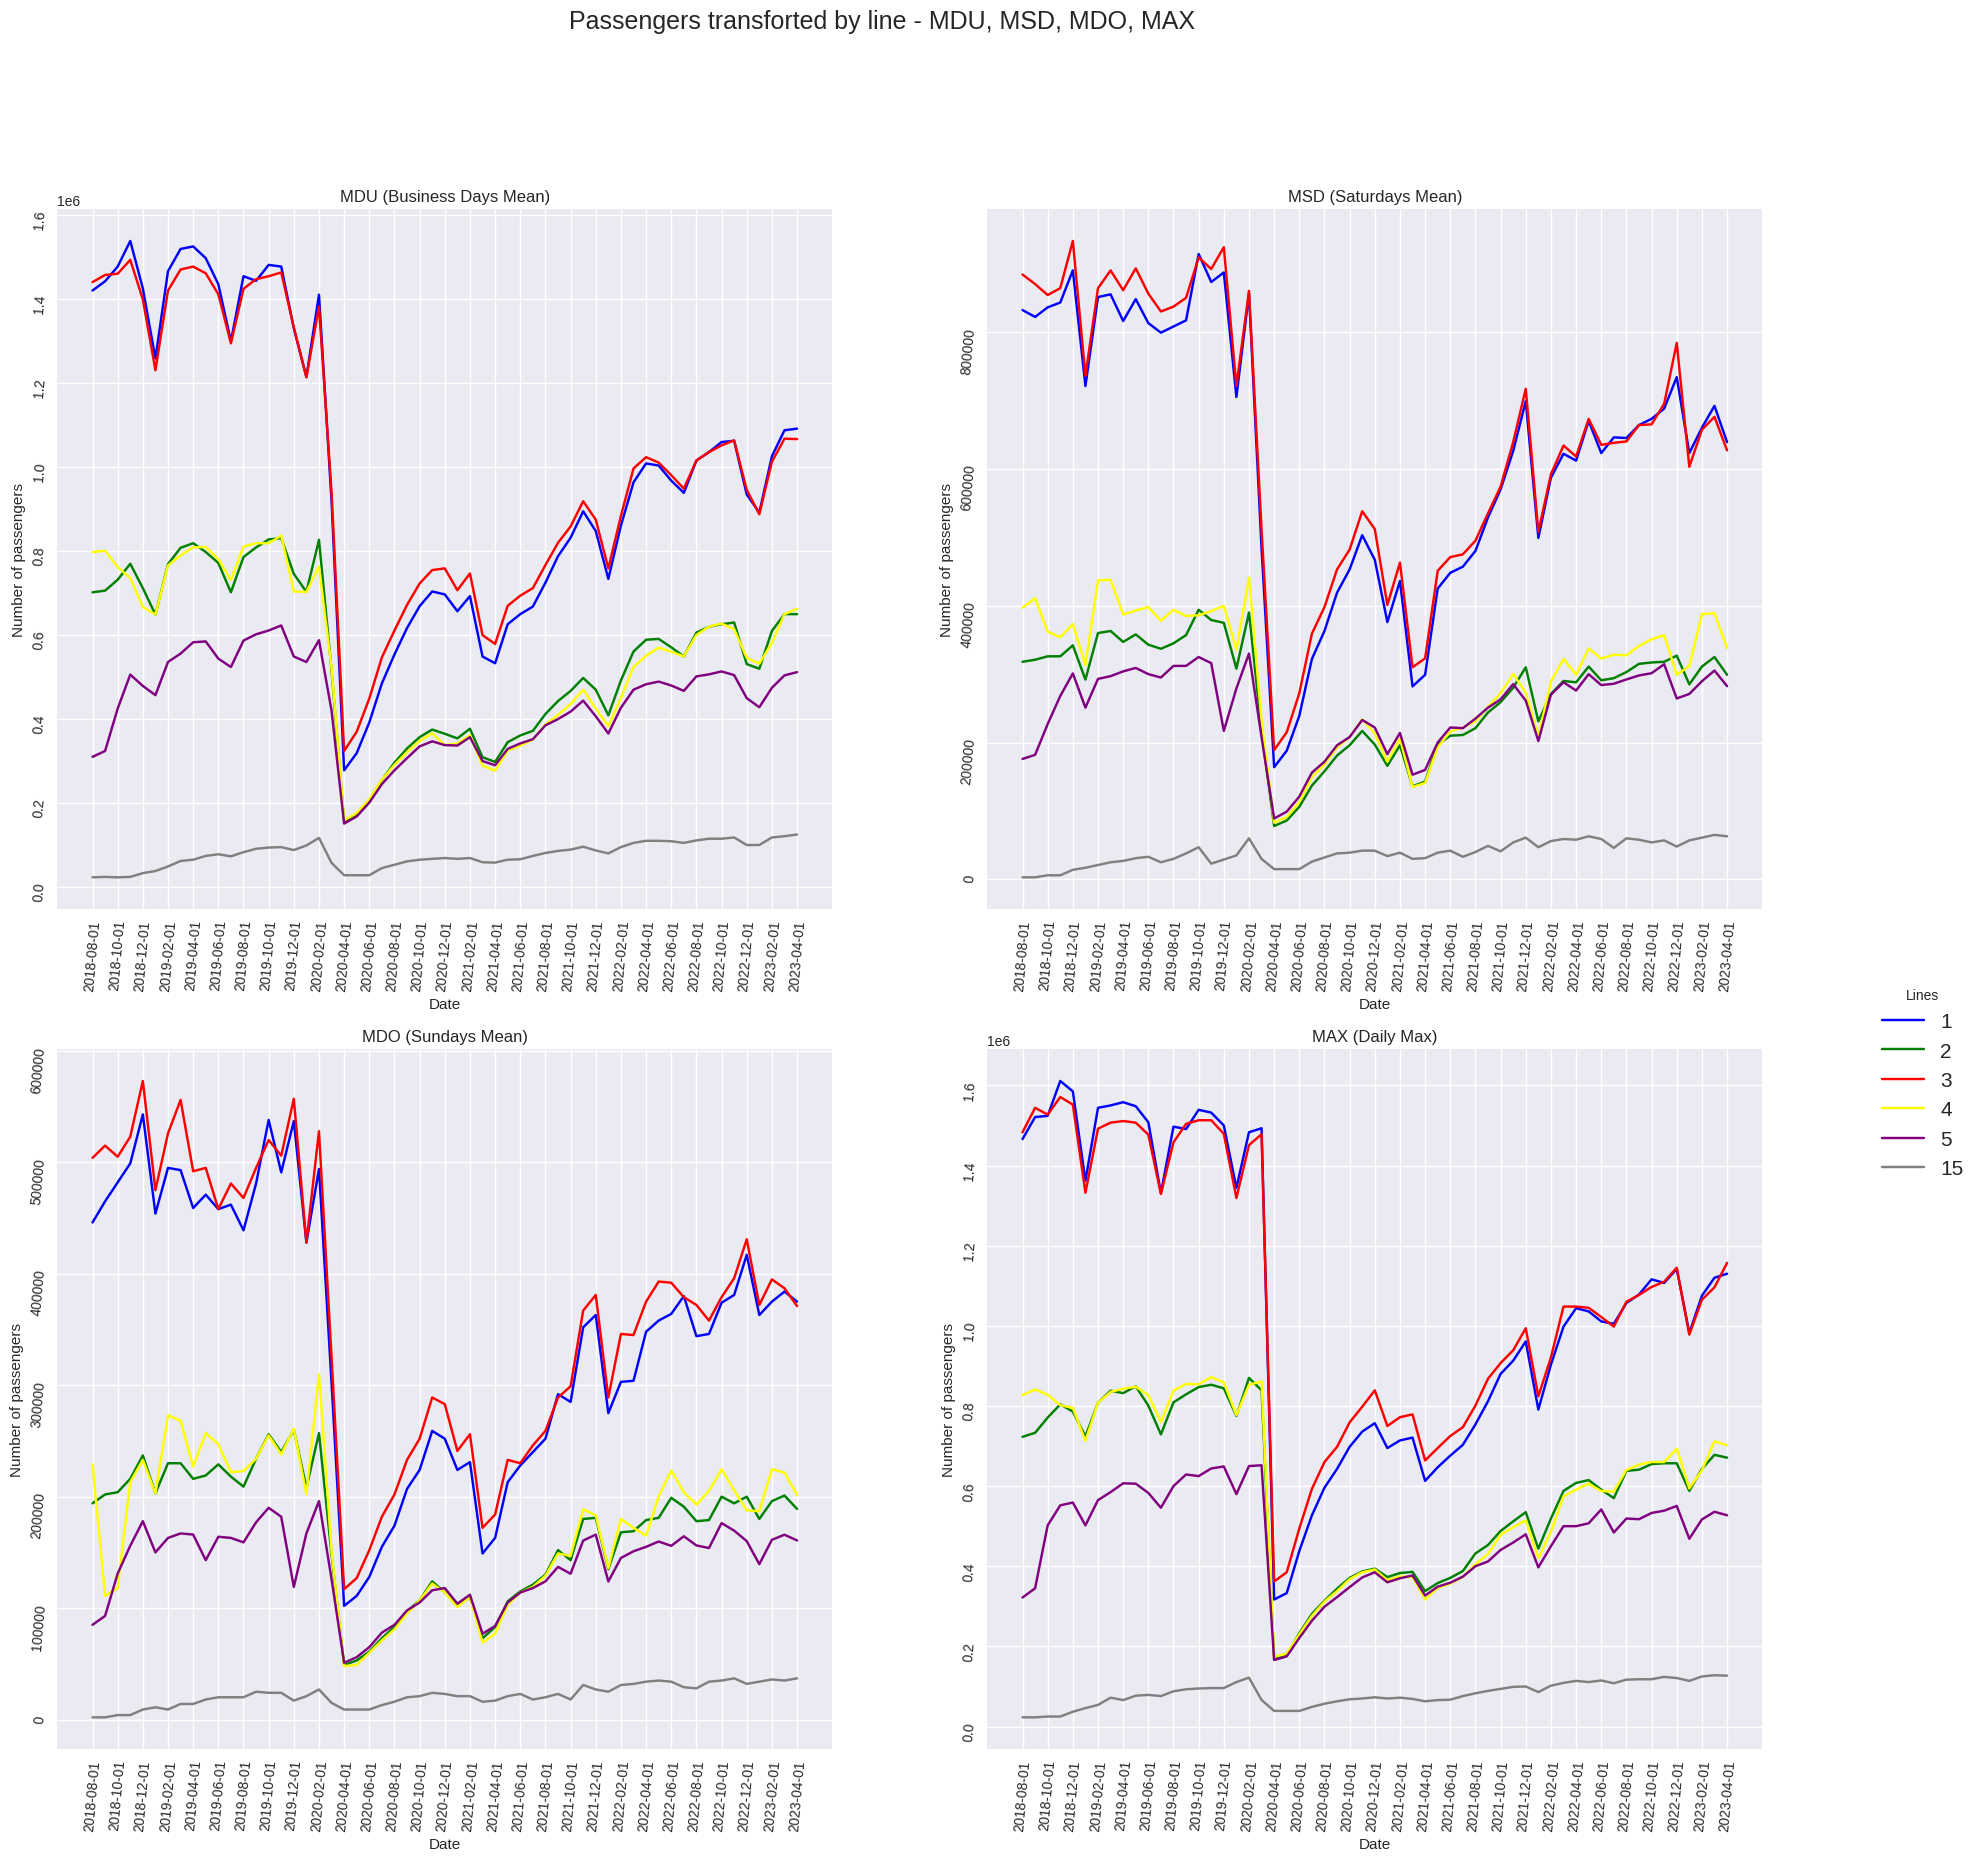

In [27]:
figure = plt.figure(figsize=(22, 20))
axs = figure.subplots(nrows=2, ncols=2)
figure.suptitle('Passengers transforted by line - MDU, MSD, MDO, MAX', fontsize=18)

axs[0][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDU (Business Days Mean)'], label='Line 1', color=color_lines[1])
axs[0][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDU (Business Days Mean)'], label='Line 2', color=color_lines[2])
axs[0][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDU (Business Days Mean)'], label='Line 3', color=color_lines[3])
axs[0][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDU (Business Days Mean)'], label='Line 4', color=color_lines[4])
axs[0][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDU (Business Days Mean)'], label='Line 5', color=color_lines[5])
axs[0][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDU (Business Days Mean)'], label='Line 15', color=color_lines[15])
axs[0][0].set_title('MDU (Business Days Mean)')
axs[0][0].set_xlabel('Date')
axs[0][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][0].tick_params(labelrotation=85)
axs[0][0].set_ylabel('Number of passengers')

axs[0][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MSD (Saturdays Mean)'], label='Line 1', color=color_lines[1])
axs[0][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MSD (Saturdays Mean)'], label='Line 2', color=color_lines[2])
axs[0][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MSD (Saturdays Mean)'], label='Line 3', color=color_lines[3])
axs[0][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MSD (Saturdays Mean)'], label='Line 4', color=color_lines[4])
axs[0][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MSD (Saturdays Mean)'], label='Line 5', color=color_lines[5])
axs[0][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MSD (Saturdays Mean)'], label='Line 15', color=color_lines[15])
axs[0][1].set_title('MSD (Saturdays Mean)')
axs[0][1].set_xlabel('Date')
axs[0][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][1].tick_params(labelrotation=85)
axs[0][1].set_ylabel('Number of passengers')

axs[1][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDO (Sundays Mean)'], label='Line 1', color=color_lines[1])
axs[1][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDO (Sundays Mean)'], label='Line 2', color=color_lines[2])
axs[1][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDO (Sundays Mean)'], label='Line 3', color=color_lines[3])
axs[1][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDO (Sundays Mean)'], label='Line 4', color=color_lines[4])
axs[1][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDO (Sundays Mean)'], label='Line 5', color=color_lines[5])
axs[1][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDO (Sundays Mean)'], label='Line 15', color=color_lines[15])
axs[1][0].set_title('MDO (Sundays Mean)')
axs[1][0].set_xlabel('Date')
axs[1][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][0].tick_params(labelrotation=85)
axs[1][0].set_ylabel('Number of passengers')

axs[1][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MAX (Daily Max)'], label='Line 1', color=color_lines[1])
axs[1][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MAX (Daily Max)'], label='Line 2', color=color_lines[2])
axs[1][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MAX (Daily Max)'], label='Line 3', color=color_lines[3])
axs[1][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MAX (Daily Max)'], label='Line 4', color=color_lines[4])
axs[1][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MAX (Daily Max)'], label='Line 5', color=color_lines[5])
axs[1][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MAX (Daily Max)'], label='Line 15', color=color_lines[15])
axs[1][1].set_title('MAX (Daily Max)')
axs[1][1].set_xlabel('Date')
axs[1][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][1].tick_params(labelrotation=85)
axs[1][1].set_ylabel('Number of passengers')

figure.legend(labels=color_lines.keys(),bbox_to_anchor=(0.5, 0., 0.5, 0.5), title='Lines', fontsize=15)
plt.show()

### Lines 1 and 3 participation

In [28]:
df_02 = deepcopy(df.reset_index())

In [29]:
totals = df_02.groupby(by='year_month').sum().drop(labels='line', axis=1).loc[:,'total']

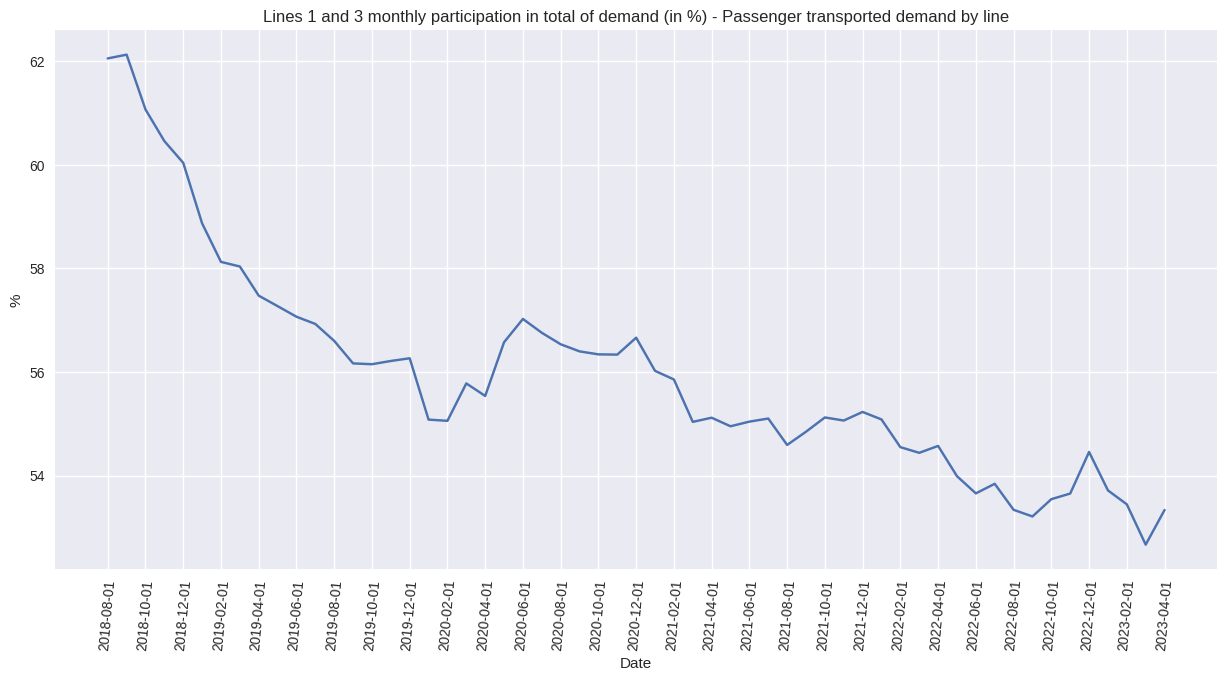

In [30]:
line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line1_line2 = ((line_01_sum + line_03_sum) / totals) * 100

figure = plt.figure(figsize=(15,7))
plt.plot(participation_line1_line2)
plt.title('Lines 1 and 3 monthly participation in total of demand (in %) - Passenger transported demand by line')
plt.xlabel('Date')
plt.xticks(ticks=list(np.unique(df.index))[::2], rotation=85)
plt.ylabel('%')
plt.show()

### The participation of each line in the total demand.

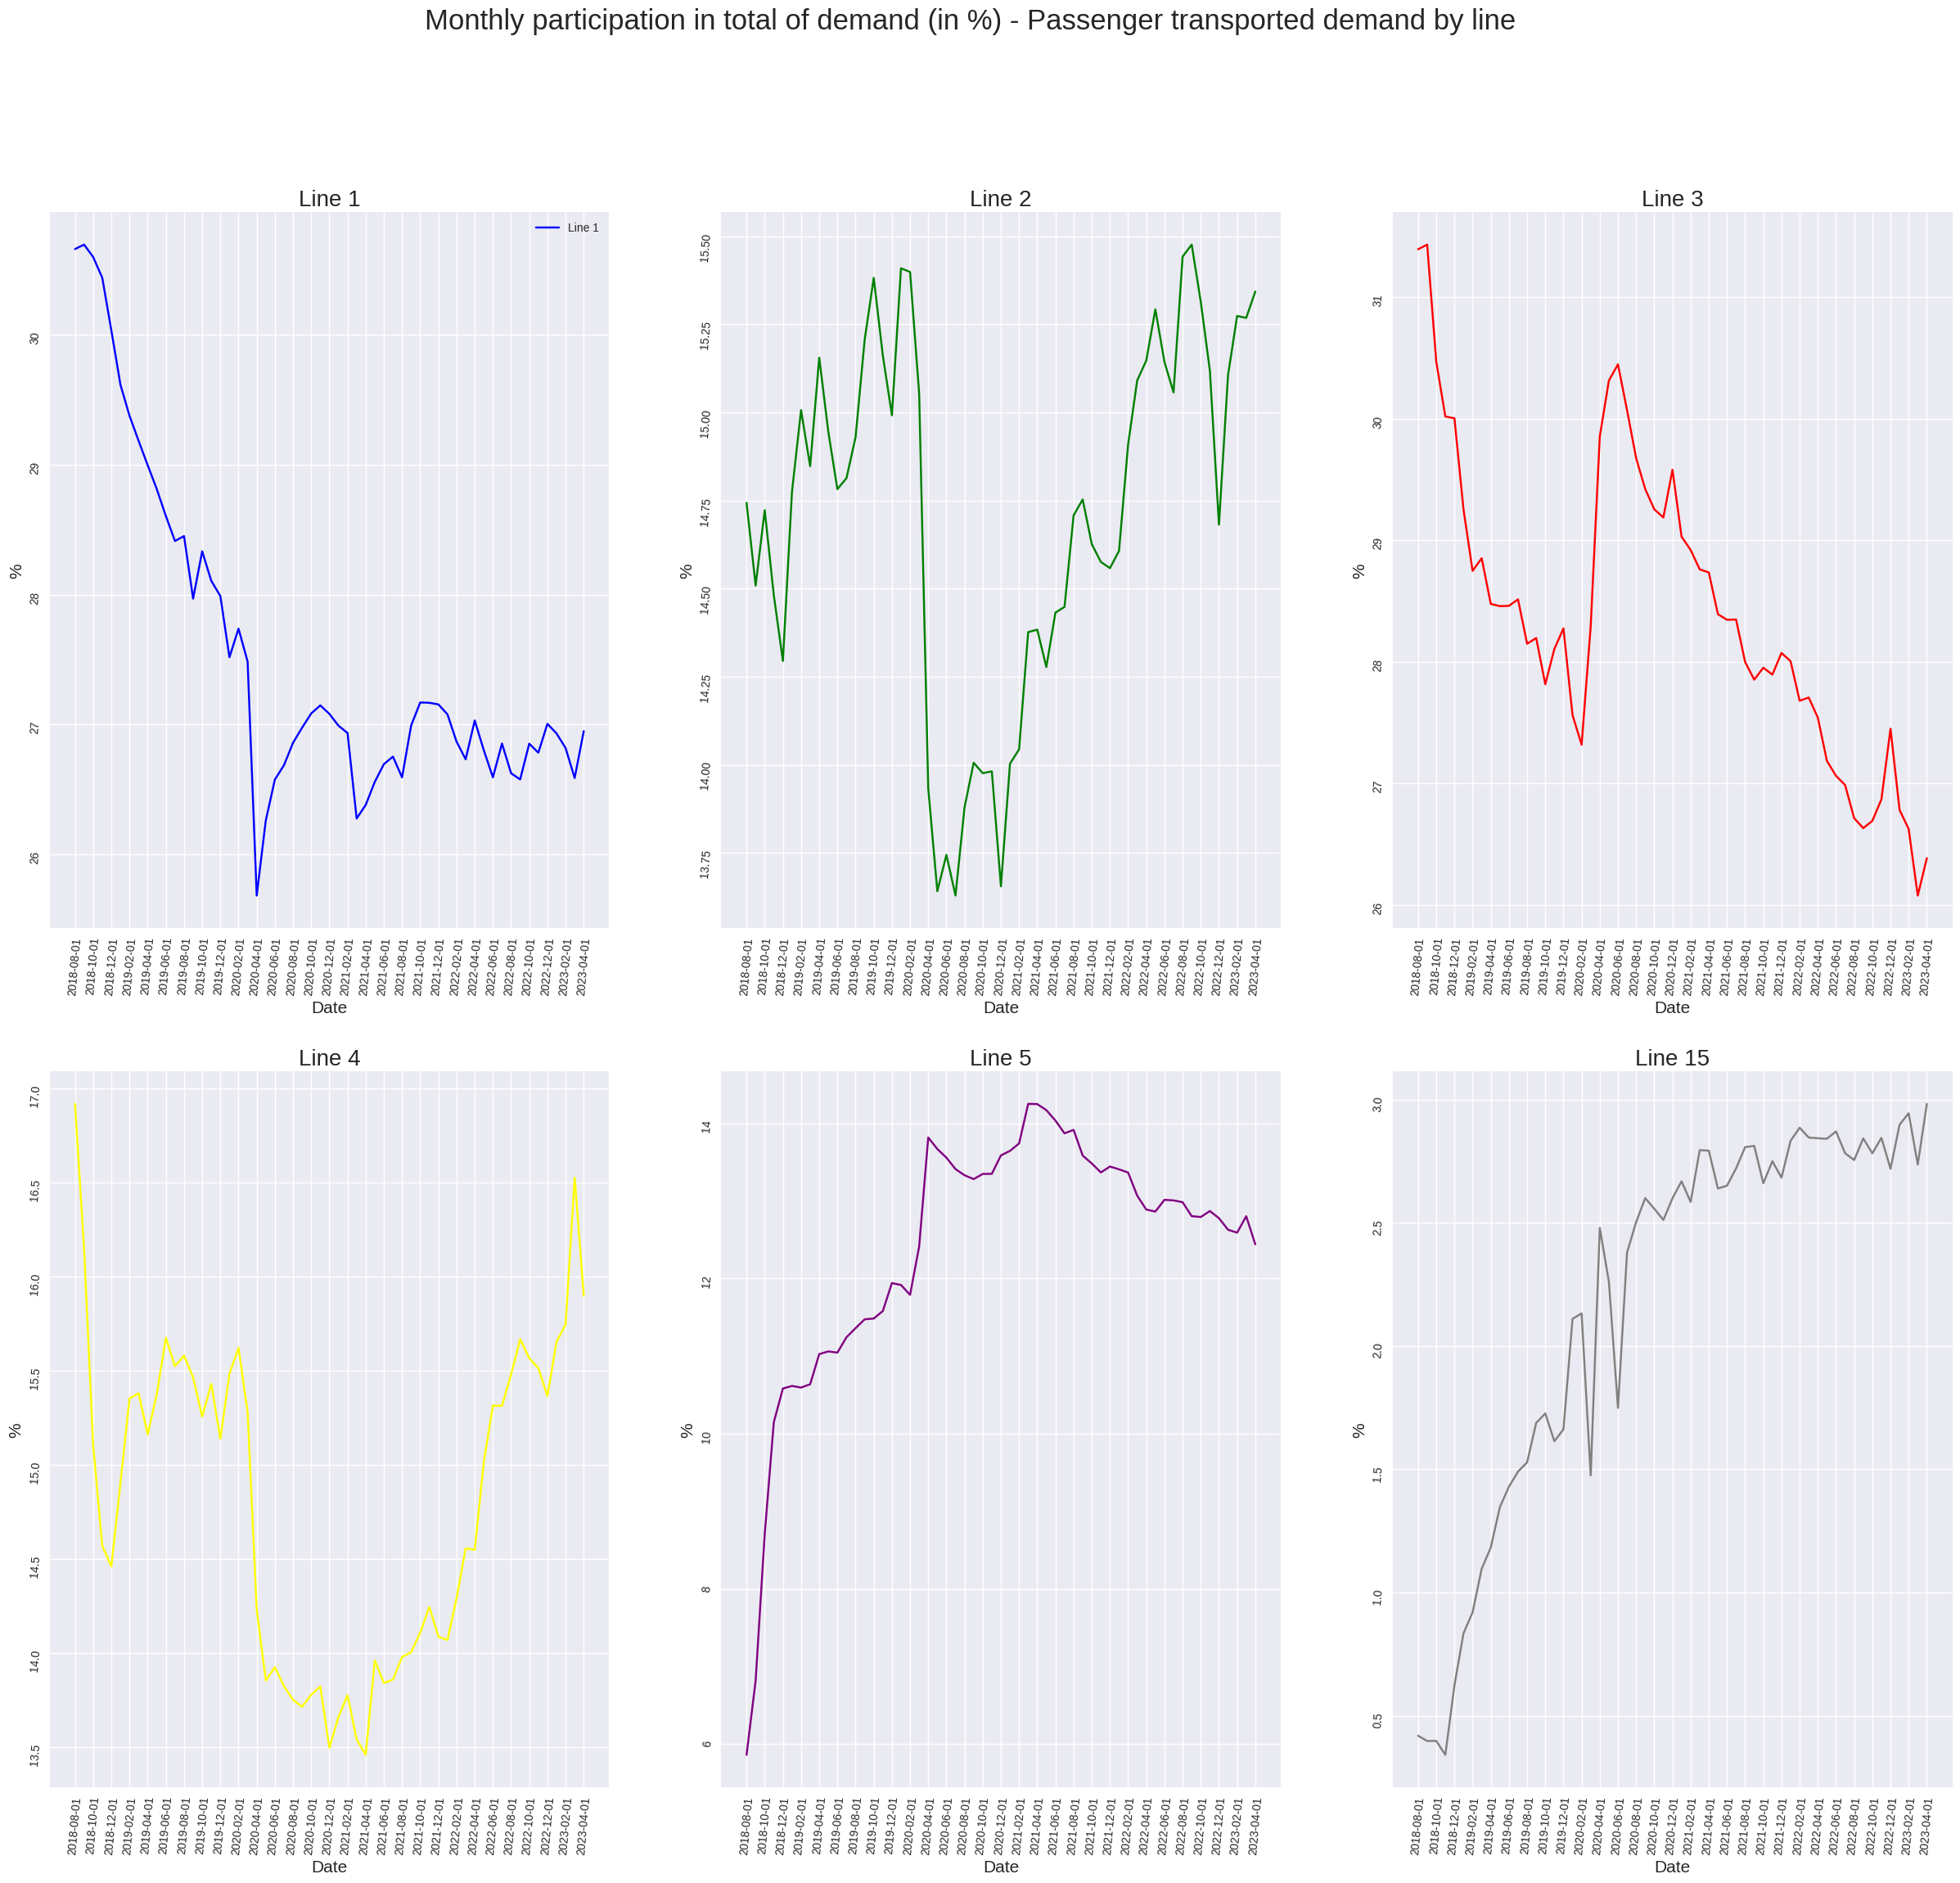

In [31]:
figure = plt.figure(figsize=(30, 25))
axs = figure.subplots(nrows=2, ncols=3)
figure.suptitle('Monthly participation in total of demand (in %) - Passenger transported demand by line', fontsize=25)

line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
participation_line1 = (line_01_sum / totals) * 100
axs[0][0].plot(participation_line1, color=color_lines[1], label='Line 1')
axs[0][0].set_title('Line 1', fontsize=20)
axs[0][0].set_xlabel('Date', fontsize=15)
axs[0][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][0].tick_params(labelrotation=85)
axs[0][0].set_ylabel('%', size=15)
axs[0][0].legend()

line_02_sum = df[df.loc[:,'line'] == 2].loc[:,'total']
participation_line2 = (line_02_sum / totals) * 100
axs[0][1].plot(participation_line2, color=color_lines[2])
axs[0][1].set_title('Line 2', fontsize=20)
axs[0][1].set_xlabel('Date', fontsize=15)
axs[0][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][1].tick_params(labelrotation=85)
axs[0][1].set_ylabel('%', fontsize=15)

line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line3 = (line_03_sum / totals) * 100
axs[0][2].plot(participation_line3, color=color_lines[3])
axs[0][2].set_title('Line 3', fontsize=20)
axs[0][2].set_xlabel('Date', fontsize=15)
axs[0][2].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][2].tick_params(labelrotation=85)
axs[0][2].set_ylabel('%', fontsize=15)

line_04_sum = df[df.loc[:,'line'] == 4].loc[:,'total']
participation_line4 = (line_04_sum / totals) * 100
axs[1][0].plot(participation_line4, color=color_lines[4])
axs[1][0].set_title('Line 4', fontsize=20)
axs[1][0].set_xlabel('Date', fontsize=15)
axs[1][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][0].tick_params(labelrotation=85)
axs[1][0].set_ylabel('%', fontsize=15)

line_05_sum = df[df.loc[:,'line'] == 5].loc[:,'total']
participation_line5 = (line_05_sum / totals) * 100
axs[1][1].plot(participation_line5, color=color_lines[5])
axs[1][1].set_title('Line 5', fontsize=20)
axs[1][1].set_xlabel('Date', fontsize=15)
axs[1][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][1].tick_params(labelrotation=85)
axs[1][1].set_ylabel('%', fontsize=15)

line_15_sum = df[df.loc[:,'line'] == 15].loc[:,'total']
participation_line15 = (line_15_sum / totals) * 100
axs[1][2].plot(participation_line15, color=color_lines[15])
axs[1][2].set_title('Line 15', fontsize=20)
axs[1][2].set_xlabel('Date', fontsize=15)
axs[1][2].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][2].tick_params(labelrotation=85)
axs[1][2].set_ylabel('%', fontsize=15)

plt.show()